# VK CUP


### Описание задачи -- Vk Ads Auction Forecasting Challenge

Реклама ВКонтакте работает по тем же принципам, что и большинство рекламных систем – на основе аукциона (тут можно ссылку на мой доклад из VK Tech). Чем больше рекламодатель готов заплатить за показ рекламы пользователю – тем больше людей увидят его рекламу.   

Ваша задача – предсказать, какое количество людей увидят конкретное рекламное объявление в будущем.

#### Метрика оценки задачи

Задача оценивается по метрике, которая считается значениям из всех трех колонок –`at_least_one`, `at_least_two` и `at_least_three`.

Метрика – Smoothed Mean Log Accuracy Ratio, переведенная в проценты.

$$ 100\% \cdot \left( \exp \left( \frac{1}{n} \sum_{i=1}^{n}\left|\log\left(\frac{ Predicted_i + \epsilon}{Actual_i + \epsilon}\right)\right| \right) - 1 \right) $$

EPS = 0.005

Метрика интерпретируется следующим образом: это среднее значение относительного расхождения эталона и предсказанного значения в процентах. 

Например, значение 30% значит, что в среднем модель ошибается на 30% от реальности. Чем ближе метрика к 0 – тем лучше.

Сглаживание в метрике нужно, чтобы уменьшить влияние относительной ошибки там, где эталон близок к нулю. 

Логарифм в метрике берется для того, чтобы overpredict и underpredict расчитывались симметрично.


####  Важные условия работы аукциона и условности задачи:
- Если ставка объявления `cpm` больше всех ставок всех остальных участников: со 100% вероятность выигрывает объявление со ставкой `cpm`
- Если ставка объявления `cpm` равна максимальной ставке среди всех остальных участников: объявление со ставкой `cpm` выигрывает с вероятностью в 50%. В реальном аукционе объявление может выигрывать по совершенно другим правилам и вероятностям, это упрощение для моделирования конкретно в данном датасете. 
- Система запоминает все объявления, который видел пользователь в течении сессии и не показывает их, даже если это самые дорогие объявления в аукционе.  Новая сессия начинается после отсутсвия показов рекламы пользователю в течении 6 часов.


Ваш алгоритм будет тестироваться на следующем месяце, после доступной вам истории показов. То есть, hour_start и hour_end в тестовых заданиях не будут пересекаться с hour из доступной вам `history.tsv`.

Пользователи в тестовых заданиях будут выбраны из `users.tsv`, который вам доступен.

Задания выглядят идентично заданиям из `validate.tsv`, вывод (TARGET) ожидается ровно в таком же формате, что и `validate_answers.tsv`.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_users = pd.read_csv('users.tsv', sep='\t', header=0)
df_hist = pd.read_csv('history.tsv', sep='\t', header=0)
df_val = pd.read_csv('validate.tsv', sep='\t', header=0)
df_val_ans = pd.read_csv('validate_answers.tsv', sep='\t', header=0)

In [4]:
print(f'Количество дублей в df_users: {df_users.duplicated().sum()}')
print(f'Количество пропусков в df_users: \n{df_users.isnull().sum()}', end='\n\n')

print(f'Количество дублей в df_hist: {df_hist.duplicated().sum()}')
print(f'Количество пропусков в df_hist: \n{df_hist.isnull().sum()}', end='\n\n')

print(f'Количество дублей в df_val: {df_val.duplicated().sum()}')
print(f'Количество пропусков в df_val: \n{df_val.isnull().sum()}', end='\n\n')

print(f'Количество дублей в df_val_ans: {df_val_ans.duplicated().sum()}')
print(f'Количество пропусков в df_val_ans: \n{df_val_ans.isnull().sum()}', end='\n\n')

Количество дублей в df_users: 0
Количество пропусков в df_users: 
user_id    0
sex        0
age        0
city_id    0
dtype: int64

Количество дублей в df_hist: 22190
Количество пропусков в df_hist: 
hour         0
cpm          0
publisher    0
user_id      0
dtype: int64

Количество дублей в df_val: 0
Количество пропусков в df_val: 
cpm              0
hour_start       0
hour_end         0
publishers       0
audience_size    0
user_ids         0
dtype: int64

Количество дублей в df_val_ans: 130
Количество пропусков в df_val_ans: 
at_least_one      0
at_least_two      0
at_least_three    0
dtype: int64



Удалим дубликаты в количестве 22 190 в датасете `df_hist`. Из датасета с таргетами `val_answers` удалять не будем, чтобы не нарушить соответствие строк с датасетом `validate`

In [5]:
df_hist.drop_duplicates(inplace=True)
df_hist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1125667 entries, 0 to 1147856
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   hour       1125667 non-null  int64  
 1   cpm        1125667 non-null  float64
 2   publisher  1125667 non-null  int64  
 3   user_id    1125667 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 42.9 MB


Пропуски данных отсутствуют.

#### `users.tsv` - датасет пользователей 
- `user_id` – уникальный идентификатор пользователя
- `sex` – указанный пользователем пол в анкете
- `age` – указанный пользователем в анкете возраст пользователя. 0 – не указан.
- `city_id` - указанный пользователем в анкете город проживания. 0 – не указан.

In [6]:
df_users.head()

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4


In [7]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27769 entries, 0 to 27768
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  27769 non-null  int64
 1   sex      27769 non-null  int64
 2   age      27769 non-null  int64
 3   city_id  27769 non-null  int64
dtypes: int64(4)
memory usage: 867.9 KB


Пропуски данных отсутствуют.

27 769 клиентов без пропусков данных

#### `history.tsv` - датасет показов рекламы пользователям за два последовательных месяца
- `hour` – в какой час пользователь видел объявление
- `cpm` - цена показанного рекламного объявления в рекламном аукционе. Это значит, что на данном аукционе это была максимальная ставка. 
- `publisher` - площадка, на который пользователь видел рекламу
- `user_id` - уникальный идентификатор пользователя


In [8]:
df_hist.head()

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148


In [9]:
df_hist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1125667 entries, 0 to 1147856
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   hour       1125667 non-null  int64  
 1   cpm        1125667 non-null  float64
 2   publisher  1125667 non-null  int64  
 3   user_id    1125667 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 42.9 MB


Пропуски данных отсутствуют.

#### `validate.tsv` - датасет объявлений для валидации алгоритма
- `cpm` - для какой цены объявления нужно сделать прогноз
- `hour_start` - предположительное время запуска рекламного объявления
- `hour_end` - предположительное время остановки рекламного объявления. По итогу прогноз делается для рекламного объявление, которое будет запущено в период времени `[hour_start, hour_end]`
- `publishers` - на каких площадках объявление может быть показано
- `audience_size` - размер аудитории объявления, количество идентификаторов в поле `user_ids`
- `user_ids` – аудитория объявления – список пользователей, кому рекламодатель хочет показать объявление.

In [10]:
df_val.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1..."
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3..."
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5..."
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524..."
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2..."


In [11]:
df_val.describe()

,cpm,hour_start,hour_end,audience_size
count,1008.000000,1008.000000,1008.000000,1008.000000
mean,162.425595,1065.046627,1166.225198,1090.087302
std,112.192984,192.984789,192.168496,613.557243
min,30.000000,747.000000,753.000000,300.000000
25%,79.000000,906.000000,1019.000000,575.000000
50%,130.000000,1048.000000,1184.000000,960.000000
75%,220.000000,1214.250000,1325.250000,1464.000000
max,475.000000,1485.000000,1488.000000,2500.000000


In [12]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cpm            1008 non-null   float64
 1   hour_start     1008 non-null   int64  
 2   hour_end       1008 non-null   int64  
 3   publishers     1008 non-null   object 
 4   audience_size  1008 non-null   int64  
 5   user_ids       1008 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 47.4+ KB


Пропуски данных отсутствуют.

#### `validate_answers.tsv` - датасет эталонных ответов алгоритма для валидационного датасета
- `at_least_one` - доля пользователей, которая увидит объявление хотя бы один раз
- `at_least_two` - доля пользователей, которая увидит объявление хотя бы два раза
- `at_least_three` - доля пользователей, которая увидит объявление хотя бы три раза

##### target
Вывод ожидается ровно в таком же формате, что и `validate_answers.tsv`.

In [13]:
df_val_ans.head()

,at_least_one,at_least_two,at_least_three
0,0.0430,0.0152,0.0073
1,0.0130,0.0000,0.0000
2,0.0878,0.0135,0.0000
3,0.2295,0.1295,0.0727
4,0.3963,0.2785,0.2270


In [14]:
df_val_ans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   at_least_one    1008 non-null   float64
 1   at_least_two    1008 non-null   float64
 2   at_least_three  1008 non-null   float64
dtypes: float64(3)
memory usage: 23.8 KB


Пропуски данных отсутствуют.

### Предобработка данных

Датасеты `users.tsv` и `history.tsv` имеют общий признак - `user_id`. 
Присоединим признаки пользователей к признакм истории по ID пользователя.

In [15]:
hist_users = df_hist.merge(df_users, on='user_id', how='left')

In [16]:
hist_users.head()

,hour,cpm,publisher,user_id,sex,age,city_id
0,10,30.00,1,15661,2,28,68
1,8,41.26,1,8444,1,41,0
2,7,360.00,1,15821,1,24,0
3,18,370.00,1,21530,2,17,13
4,8,195.00,2,22148,1,23,7


In [17]:
hist_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125667 entries, 0 to 1125666
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   hour       1125667 non-null  int64  
 1   cpm        1125667 non-null  float64
 2   publisher  1125667 non-null  int64  
 3   user_id    1125667 non-null  int64  
 4   sex        1125667 non-null  int64  
 5   age        1125667 non-null  int64  
 6   city_id    1125667 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 60.1 MB


In [18]:
hist_users.describe()

,hour,cpm,publisher,user_id,sex,age,city_id
count,1.125667e+06,1.125667e+06,1.125667e+06,1.125667e+06,1.125667e+06,1.125667e+06,1.125667e+06
mean,7.601468e+02,1.890819e+02,2.007746e+00,1.385085e+04,1.465243e+00,2.891653e+01,2.323170e+02
std,4.307081e+02,4.597285e+02,2.065724e+00,8.027742e+03,4.988922e-01,1.788055e+01,4.431938e+02
min,3.000000e+00,3.000000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.920000e+02,5.842000e+01,1.000000e+00,6.818000e+03,1.000000e+00,1.900000e+01,3.000000e+00
50%,7.620000e+02,1.110000e+02,1.000000e+00,1.394400e+04,1.000000e+00,2.700000e+01,3.000000e+01
75%,1.138000e+03,2.102500e+02,2.000000e+00,2.075950e+04,2.000000e+00,3.400000e+01,2.510000e+02
max,1.490000e+03,2.090540e+05,2.100000e+01,2.776800e+04,2.000000e+00,1.180000e+02,2.456000e+03


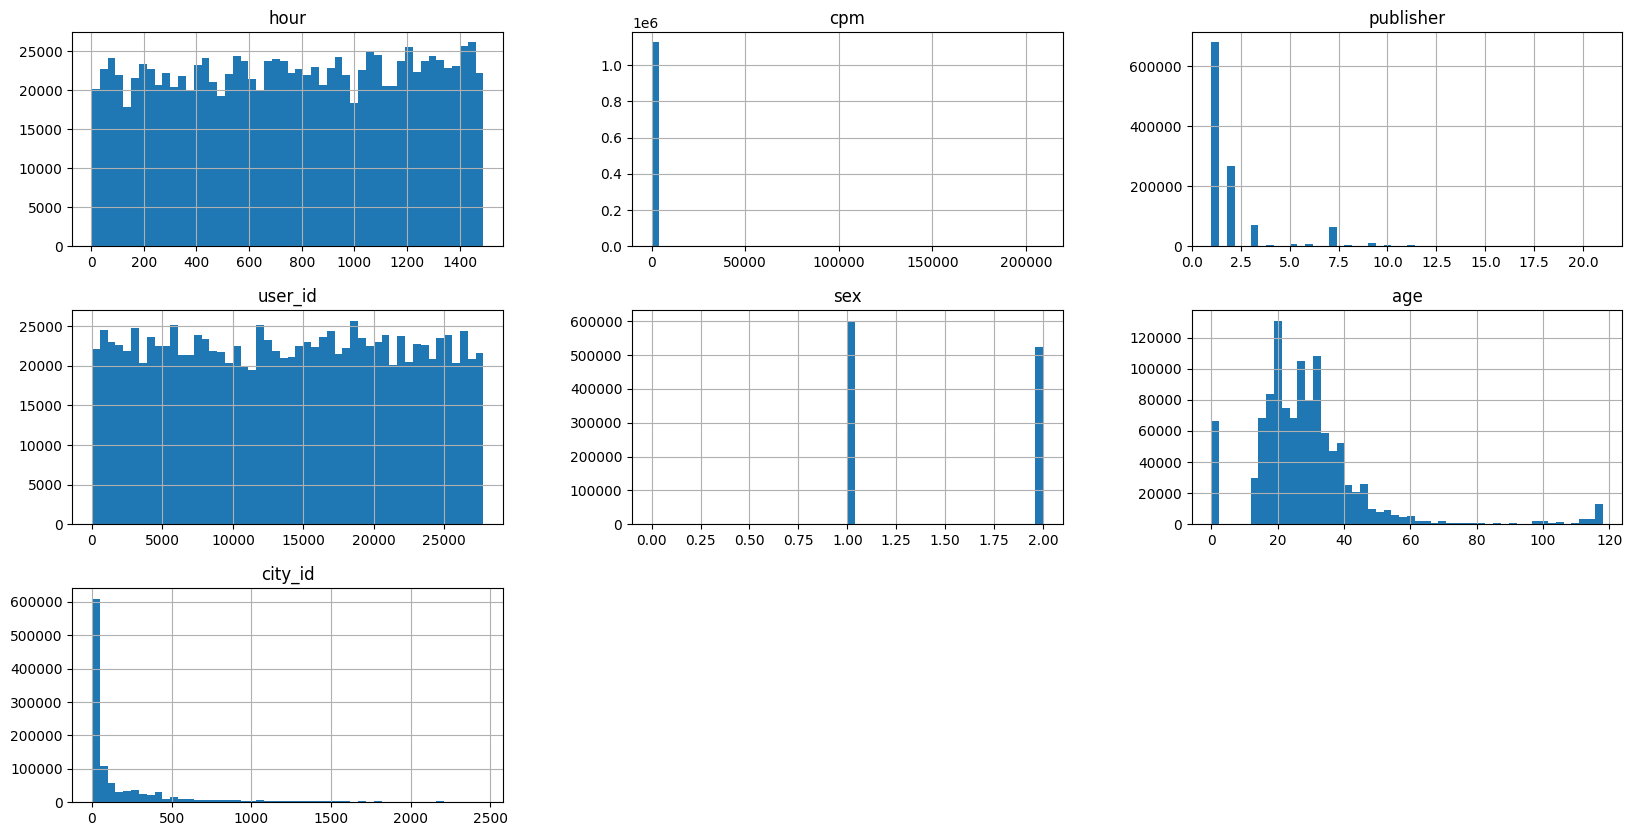

In [19]:
hist_users.hist(figsize=(20, 10), bins=50);

На графиках выявили аномальные объекты по признакам `cpm`, `city_id`, `age`, которые желательно исключить.

Признак `cpm` имеет большие аномалии, которые надо удалить. Лимит в 475 выявили в датасете `df_val`, где max значение cpm = 475

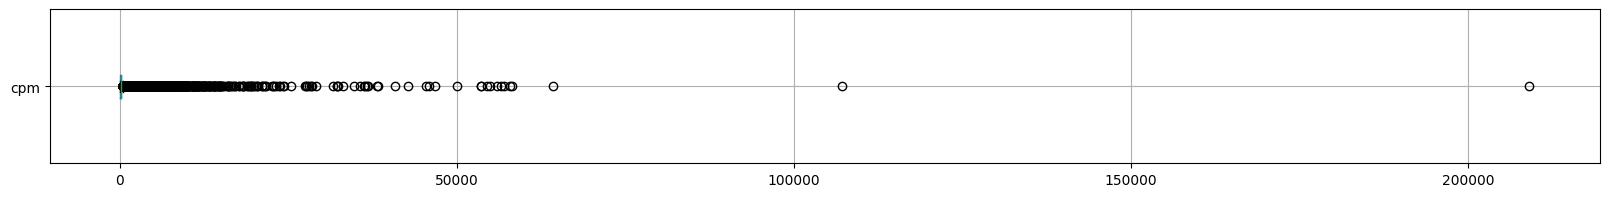

In [20]:
hist_users.boxplot(column='cpm', figsize=(20, 2), vert=False);

In [21]:
cpm_outliers = hist_users[hist_users['cpm']>475].index
hist_users.drop(cpm_outliers, inplace=True);
hist_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1046490 entries, 0 to 1125666
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   hour       1046490 non-null  int64  
 1   cpm        1046490 non-null  float64
 2   publisher  1046490 non-null  int64  
 3   user_id    1046490 non-null  int64  
 4   sex        1046490 non-null  int64  
 5   age        1046490 non-null  int64  
 6   city_id    1046490 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 63.9 MB


Удалено 79 177 строк

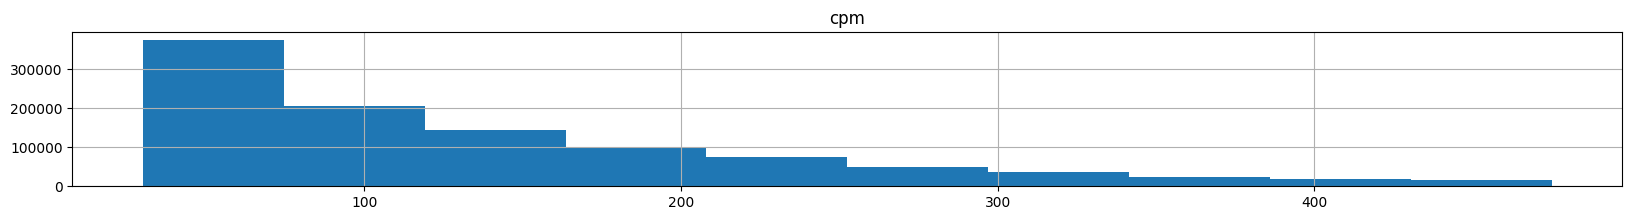

In [22]:
hist_users.hist(column='cpm', figsize=(20, 2));

In [23]:
age_outliers = hist_users[hist_users['age']>60].index
hist_users.drop(age_outliers, inplace=True);
hist_users.describe()

,hour,cpm,publisher,user_id,sex,age,city_id
count,1.009497e+06,1.009497e+06,1.009497e+06,1.009497e+06,1.009497e+06,1.009497e+06,1.009497e+06
mean,7.566653e+02,1.338232e+02,1.993501e+00,1.385241e+04,1.468884e+00,2.618679e+01,2.381650e+02
std,4.303372e+02,1.011256e+02,2.071466e+00,8.029404e+03,4.991303e-01,1.147926e+01,4.484494e+02
min,3.000000e+00,3.000000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.870000e+02,5.496000e+01,1.000000e+00,6.844000e+03,1.000000e+00,1.900000e+01,3.000000e+00
50%,7.580000e+02,1.033200e+02,1.000000e+00,1.395200e+04,1.000000e+00,2.600000e+01,3.700000e+01
75%,1.132000e+03,1.838700e+02,2.000000e+00,2.074000e+04,2.000000e+00,3.300000e+01,2.700000e+02
max,1.490000e+03,4.750000e+02,2.100000e+01,2.776800e+04,2.000000e+00,6.000000e+01,2.456000e+03


Удалено 36 994 строк

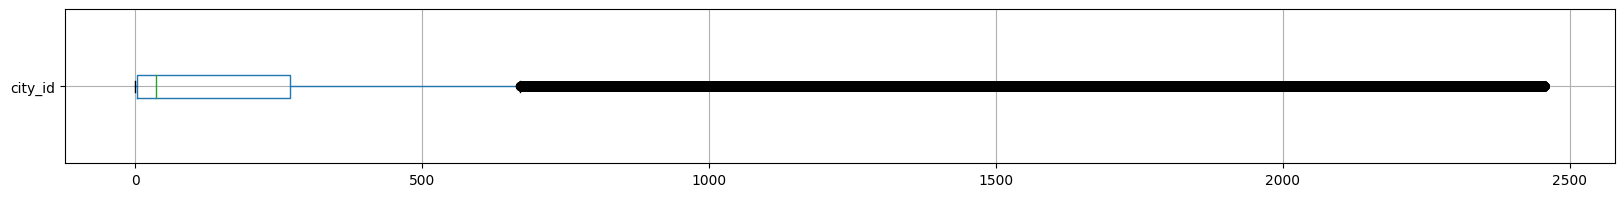

In [24]:
hist_users.boxplot(column='city_id', figsize=(20, 2), vert=False);

Признак `city_id` имеет большие аномалии, которые надо удалить. Лимит в 1374 выявили в датасете, как сумма медианного значения и 3 стандартных отклонения

In [25]:
city_out = hist_users['city_id'].median() + hist_users['city_id'].std() * 3
city_out

1382.348209006896

In [26]:
city_outliers = hist_users[hist_users['city_id']>city_out].index
hist_users.drop(city_outliers, inplace=True);
hist_users.describe()

,hour,cpm,publisher,user_id,sex,age,city_id
count,963110.000000,963110.000000,963110.000000,963110.000000,963110.000000,963110.000000,963110.000000
mean,756.077387,134.253474,1.994293,13605.619659,1.467636,26.093588,160.252957
std,430.282735,101.348248,2.068859,8061.399777,0.499056,11.476363,271.908459
min,3.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,385.000000,55.000000,1.000000,6521.250000,1.000000,19.000000,0.000000
50%,757.000000,104.480000,1.000000,13547.000000,1.000000,26.000000,25.000000
75%,1130.000000,185.000000,2.000000,20522.000000,2.000000,33.000000,202.000000
max,1490.000000,475.000000,21.000000,27768.000000,2.000000,60.000000,1382.000000


Удалено 11 306 строк

In [27]:
hist_users['city_id'].value_counts()

city_id
0       249799
3        70705
7        54468
11       14462
25       14005
         ...  
758          1
1103         1
864          1
1146         1
629          1
Name: count, Length: 1311, dtype: int64

<AxesSubplot: >

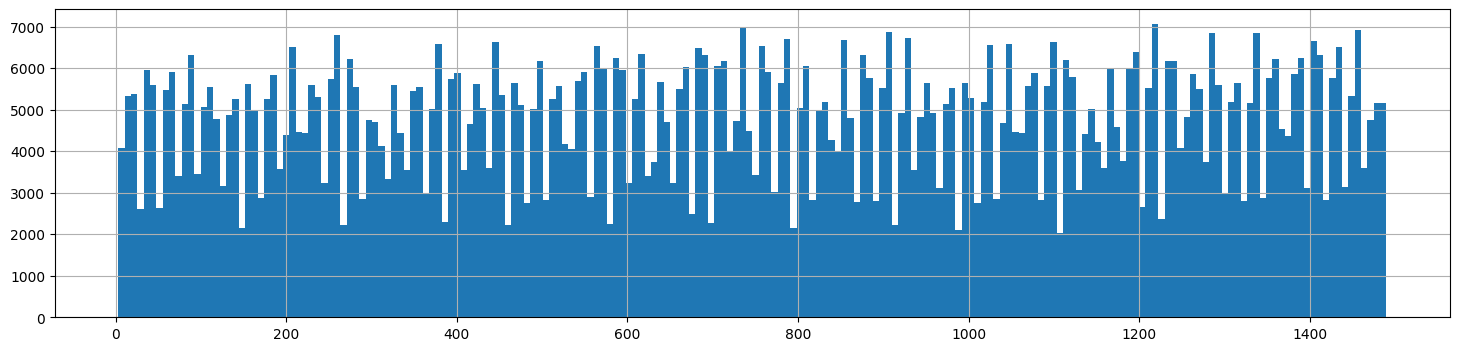

In [28]:
hist_users.hour.hist(bins=200, figsize=(18, 4))

Так выглядит динамика просмотров с течение первой недели.

<AxesSubplot: >

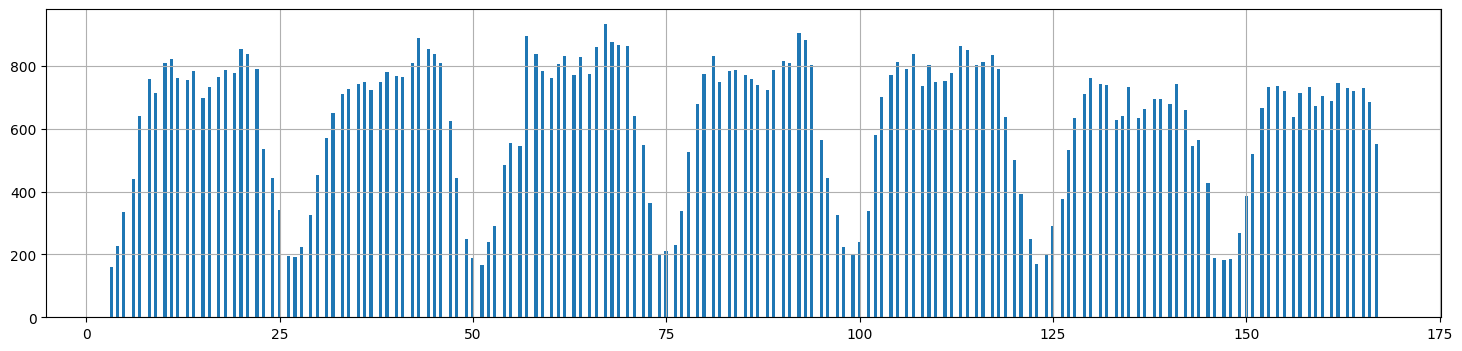

In [29]:
hist_users[hist_users.hour < 24 * 7].hour.hist(bins=400, figsize=(18, 4))

21


Text(0, 0.5, 'Визиты пользователей')

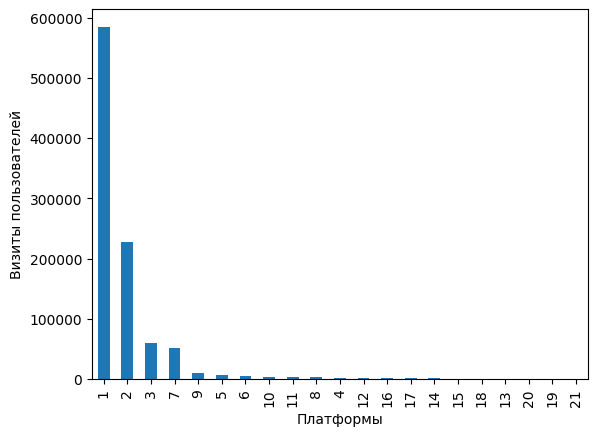

In [30]:
uniq_pubs = hist_users.publisher.unique()
print(len(uniq_pubs))
temp = hist_users.publisher.value_counts()
temp.plot(kind='bar')
plt.xlabel('Платформы')
plt.ylabel('Визиты пользователей')

Text(0, 0.5, 'Платформа')

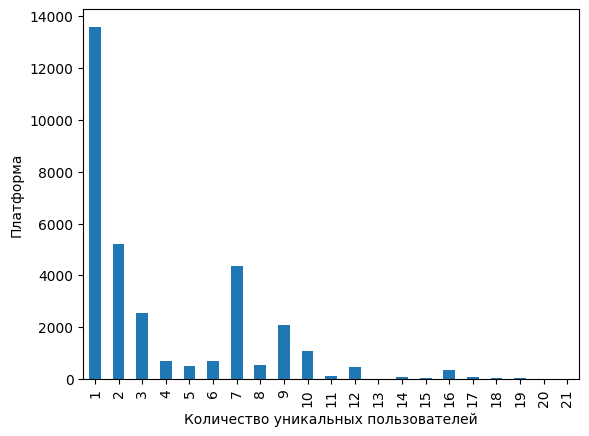

In [31]:
hist_users.groupby('publisher').user_id.apply(lambda users: len(set(users))).plot(kind='bar')
plt.xlabel('Количество уникальных пользователей')
plt.ylabel('Платформа')

In [32]:
n_publishers = len(uniq_pubs)
php = [] #posts_per_hour_by_publishers
N_HOURS = 24 * 7

for hour, hour_data in hist_users[hist_users.hour < N_HOURS].groupby('hour'):
    publishers_posts = hour_data.value_counts('publisher')

    counts = [0 for _ in range(n_publishers)]
    for pub_id, posts_n in list(publishers_posts.items()):
        counts[pub_id-1] = posts_n

    php.append([hour] + counts)


df_php = pd.DataFrame.from_records(php, columns=['hour'] + list(uniq_pubs))
df_php.head()

,hour,1,2,3,4,5,7,6,10,9,...,8,11,14,15,16,17,18,19,21,20
0,3,78,58,11,1,3,1,6,0,2,...,0,0,0,0,0,1,0,0,0,0
1,4,154,49,9,0,1,1,9,1,2,...,1,0,0,0,0,0,0,0,0,0
2,5,215,78,18,1,1,4,10,3,2,...,2,1,0,0,0,0,0,0,0,0
3,6,307,84,21,2,0,4,11,1,4,...,0,0,0,0,1,1,0,0,0,0
4,7,426,134,28,2,5,5,29,3,6,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Количество постов')

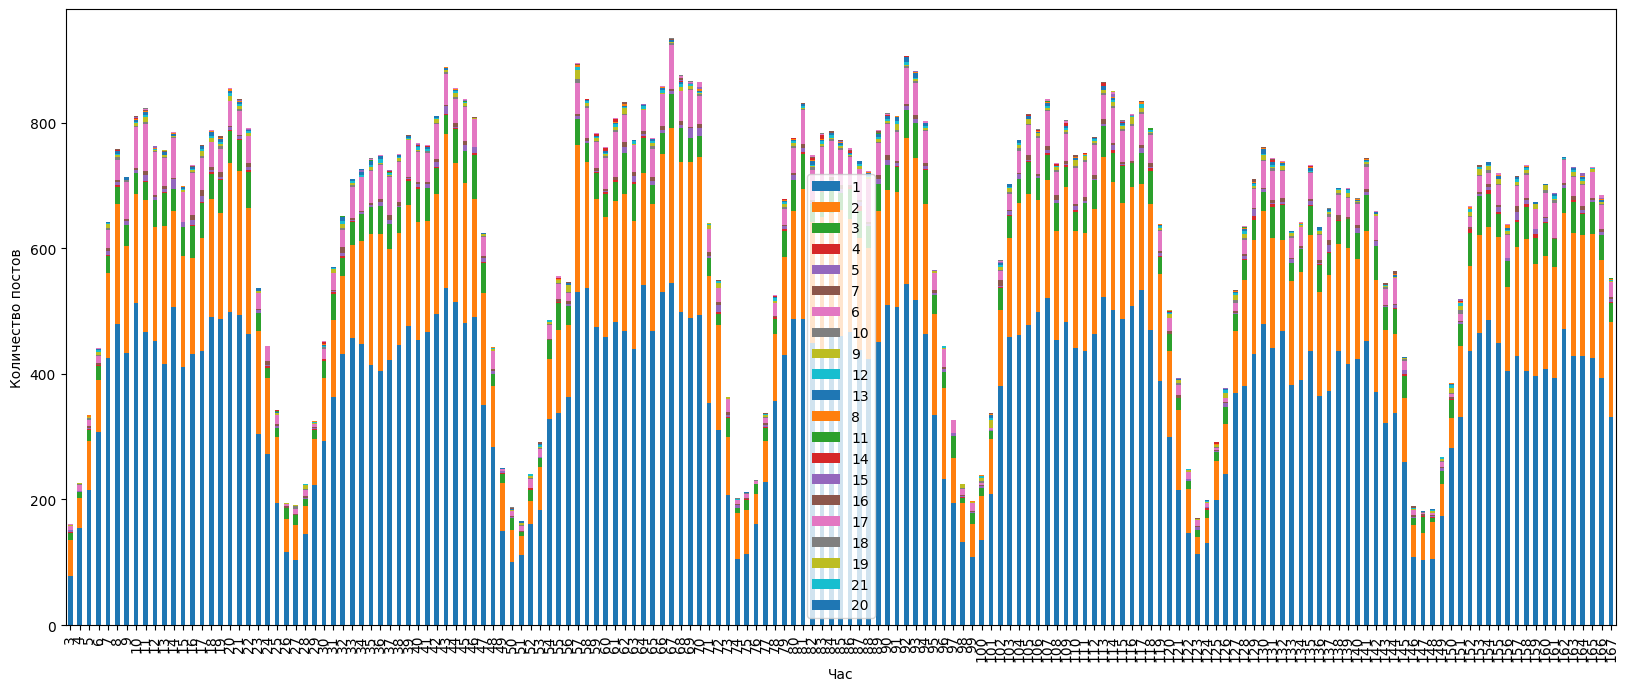

In [33]:
df_php.plot.bar(x='hour', stacked=True, figsize=(20, 8))
plt.xlabel('Час')
plt.ylabel('Количество постов')

In [34]:
hist_users.head()

,hour,cpm,publisher,user_id,sex,age,city_id
0,10,30.00,1,15661,2,28,68
1,8,41.26,1,8444,1,41,0
2,7,360.00,1,15821,1,24,0
3,18,370.00,1,21530,2,17,13
4,8,195.00,2,22148,1,23,7


Количество строк в датасетах `validate` и `validate_answers` совпадает. Есть гипотеза, что первый ключевые фичи, второй - таргет. Тогда данные в объединенном датасете `df_hist_users` (`users` и `history`) доп. фичи.

До объединения датасетов сделаем предобработку датасета `validate`

Добавим длительность торгов

In [35]:
df_val['duration'] = df_val['hour_end'] - df_val['hour_start']

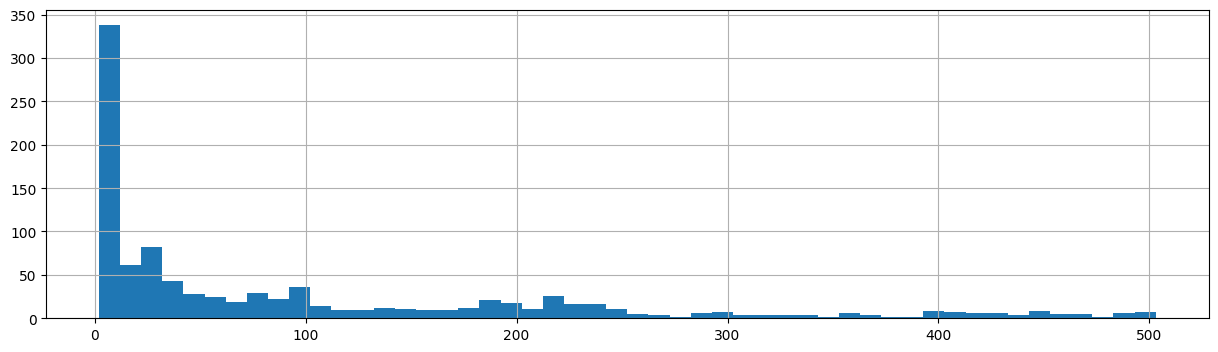

In [36]:
df_val.duration.hist(bins=50, figsize=(15, 4));

<AxesSubplot: >

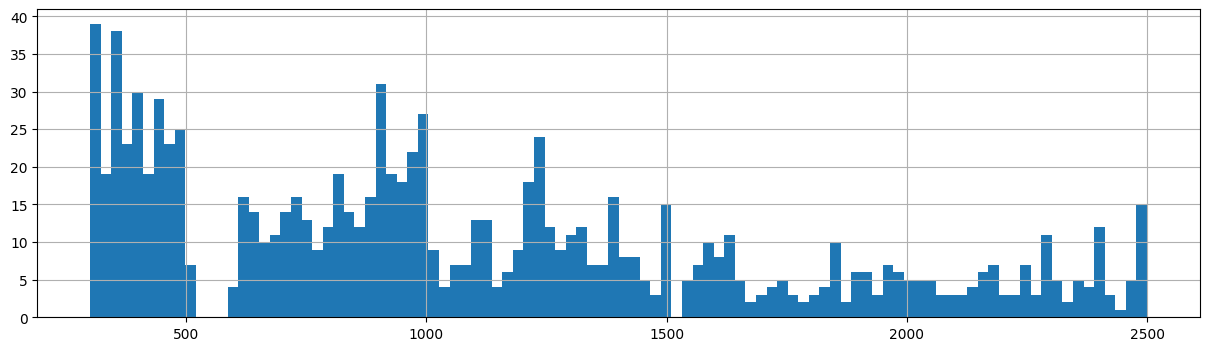

In [37]:
df_val.audience_size.hist(bins=100, figsize=(15, 4))

Сделаем обработку списков площадок и пользователей, чтобы они были списком

In [38]:
func1 = lambda x: [int(x) for x in x.split(',')]
func2 = lambda x: len(x)

In [39]:
df_val['publisher_id'] = df_val['publishers'].apply(func1)
df_val['user_id'] = df_val['user_ids'].apply(func1)

In [40]:
df_val['publishers_count'] = df_val['publisher_id'].apply(func2)

Количество площадок может быть фичей. Добавим количество. Также разделим с помощью one-hot id площадки по фичам.

In [41]:
df_val_va = pd.concat([df_val, df_val_ans], axis=1)
df_val_va.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,duration,publisher_id,user_id,publishers_count,at_least_one,at_least_two,at_least_three
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",95,"[7, 17]","[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,0.0430,0.0152,0.0073
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",6,"[3, 18]","[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",2,0.0130,0.0000,0.0000
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",20,"[1, 2, 3, 9, 15, 21]","[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",6,0.0878,0.0135,0.0000
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524...",82,"[1, 14]","[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",2,0.2295,0.1295,0.0727
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2...",238,"[1, 3, 7, 8]","[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",4,0.3963,0.2785,0.2270


In [42]:
df_val_va.drop(['publishers', 'user_ids'], inplace=True, axis=1)
df_val_va.head()

,cpm,hour_start,hour_end,audience_size,duration,publisher_id,user_id,publishers_count,at_least_one,at_least_two,at_least_three
0,220.0,1058,1153,1906,95,"[7, 17]","[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,0.0430,0.0152,0.0073
1,312.0,1295,1301,1380,6,"[3, 18]","[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",2,0.0130,0.0000,0.0000
2,70.0,1229,1249,888,20,"[1, 2, 3, 9, 15, 21]","[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",6,0.0878,0.0135,0.0000
3,240.0,1295,1377,440,82,"[1, 14]","[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",2,0.2295,0.1295,0.0727
4,262.0,752,990,1476,238,"[1, 3, 7, 8]","[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",4,0.3963,0.2785,0.2270


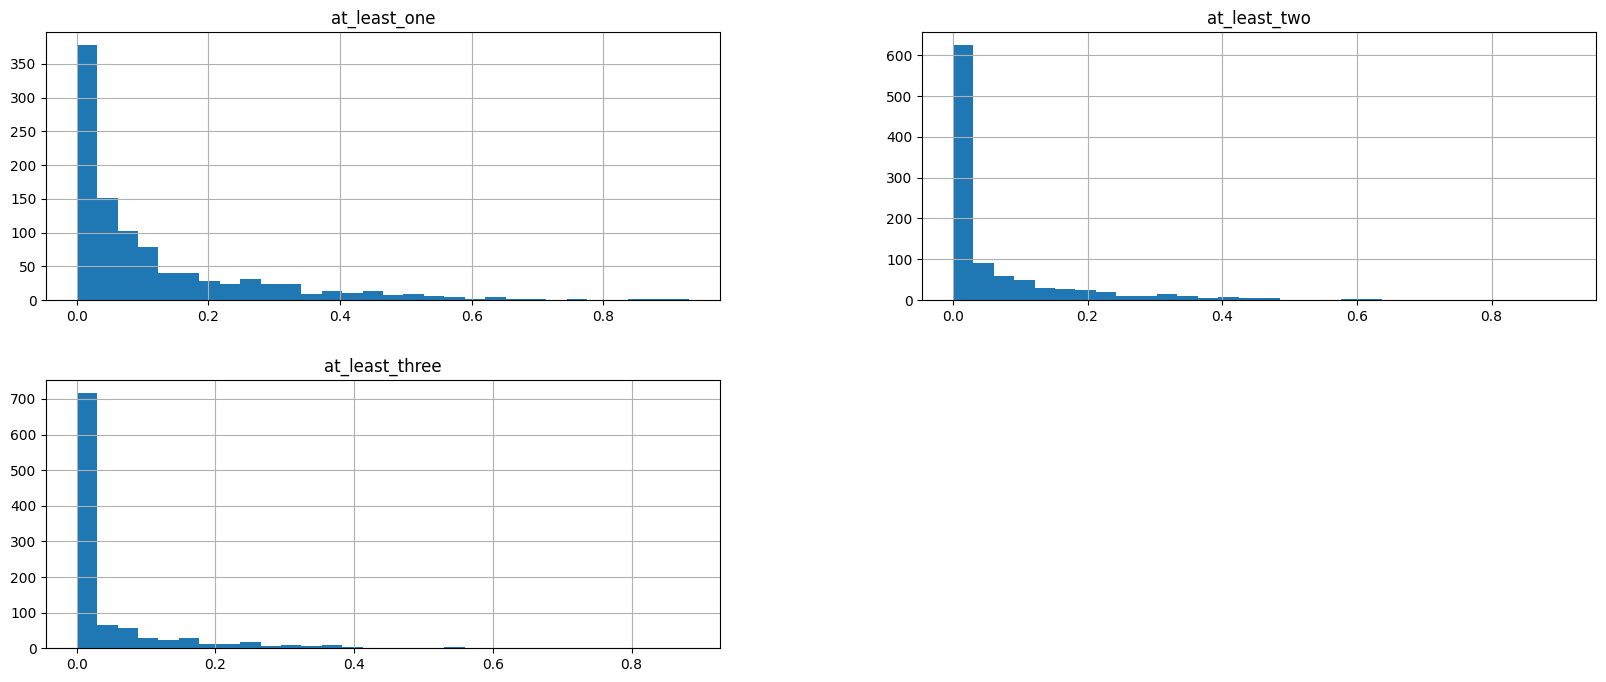

In [43]:
df_prob = df_val_va[['at_least_one', 'at_least_two', 'at_least_three']]
df_prob.hist(figsize=(20, 8), bins=30);

Оценим распределение признаков и проверим наличие у них аномалий.

Наименее сбалансированное распределение у признаков `cpm` и `time_period`.

<AxesSubplot: >

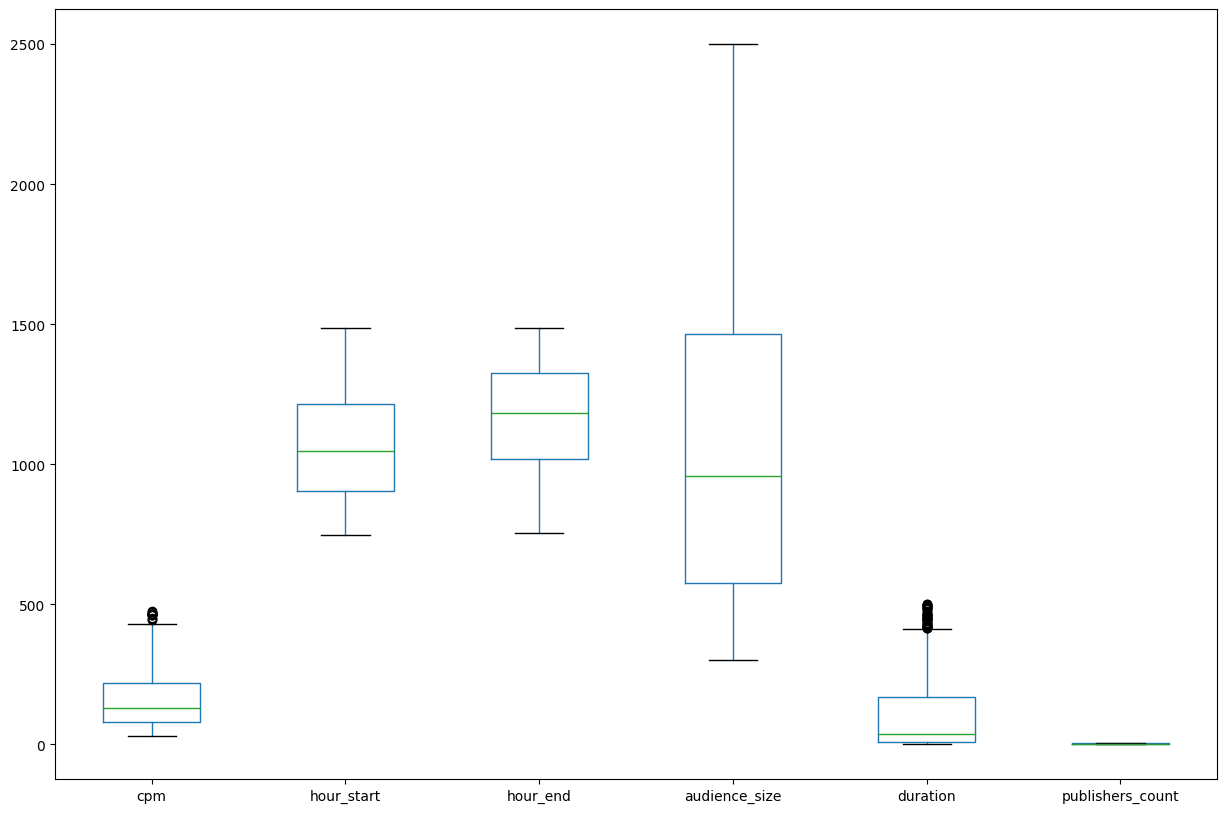

In [44]:
df_val.boxplot(figsize=(15, 10), grid=False) 

Признаки `cpm` и `time_period` имеют аномалии, которые можно исключить

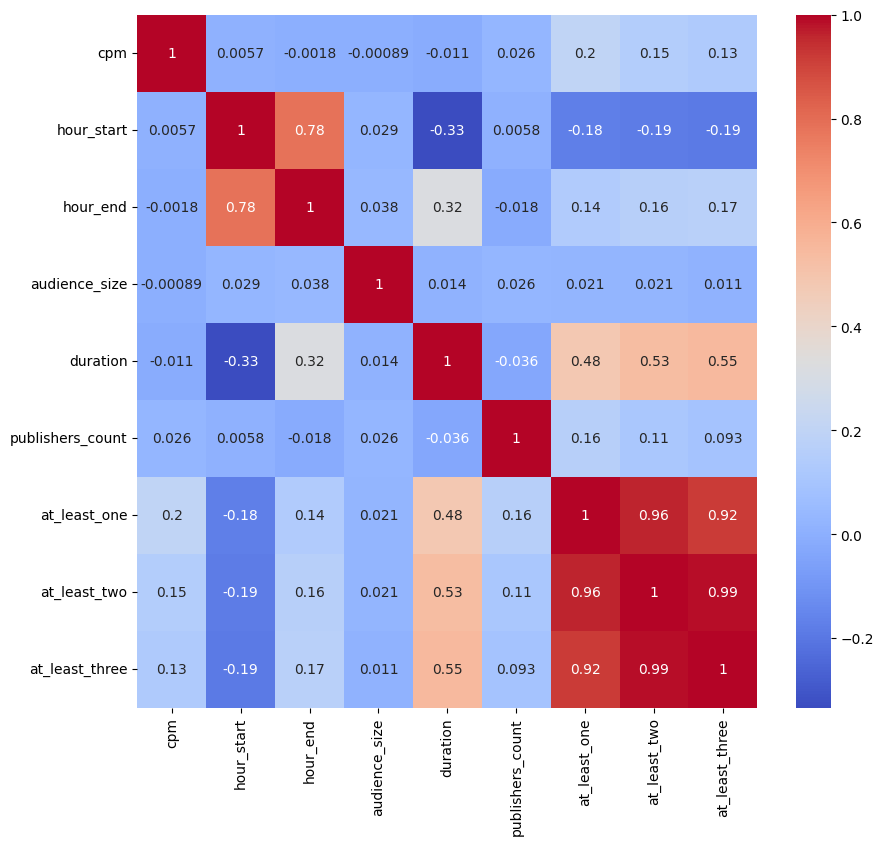

In [45]:
import seaborn as sns

df_corr = df_val_va.drop(['publisher_id', 'user_id'], axis=1)
plt.figure(figsize=(10, 9))
sns.heatmap(df_corr.corr(), cmap='coolwarm', annot = True);

Заменим признак `hour_end` из-за высокой корреляции с `hour_start` 0.78 на среднее между ними

In [46]:
len(hist_users['cpm'].unique())

38380

Очень много значений у признака `cpm` - 38 380. Чтобы свернуть `hist_users` до `df_val`, нужно сократить количество уникальных значение у признака `cpm`. Сделаем округление значений до целого числа.

In [47]:
hist_users['cpm'] = hist_users['cpm'].apply(lambda x: round(x))
len(hist_users['cpm'].unique())

446

In [48]:
func3 = lambda x: int(np.average((x['hour_start'], x['hour_end'])).round())
df_val_va['middle_hour'] = df_val_va.apply(func3, axis=1)
df_val_va.head()

,cpm,hour_start,hour_end,audience_size,duration,publisher_id,user_id,publishers_count,at_least_one,at_least_two,at_least_three,middle_hour
0,220.0,1058,1153,1906,95,"[7, 17]","[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,0.0430,0.0152,0.0073,1106
1,312.0,1295,1301,1380,6,"[3, 18]","[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",2,0.0130,0.0000,0.0000,1298
2,70.0,1229,1249,888,20,"[1, 2, 3, 9, 15, 21]","[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",6,0.0878,0.0135,0.0000,1239
3,240.0,1295,1377,440,82,"[1, 14]","[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",2,0.2295,0.1295,0.0727,1336
4,262.0,752,990,1476,238,"[1, 3, 7, 8]","[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",4,0.3963,0.2785,0.2270,871


In [74]:
df_val_va[df_val_va['publishers_count']==1]

,cpm,hour_start,hour_end,audience_size,duration,publisher_id,user_id,publishers_count,at_least_one,at_least_two,at_least_three,middle_hour
14,55.0,958,1096,848,138,[2],"[128, 142, 148, 220, 231, 246, 305, 322, 356, ...",1,0.0460,0.0224,0.0153,1027
20,106.0,976,978,1640,2,[1],"[32, 58, 70, 73, 96, 102, 127, 165, 181, 191, ...",1,0.0232,0.0000,0.0000,977
29,80.0,835,865,328,30,[1],"[11, 65, 269, 588, 612, 679, 691, 740, 802, 85...",1,0.1311,0.0488,0.0061,850
33,467.0,1200,1276,648,76,[7],"[8, 111, 145, 148, 305, 322, 375, 490, 698, 78...",1,0.0340,0.0123,0.0062,1238
34,120.0,950,1073,920,123,[1],"[10, 43, 52, 55, 138, 149, 154, 174, 243, 366,...",1,0.2261,0.1272,0.0815,1012
...,...,...,...,...,...,...,...,...,...,...,...,...
978,120.0,880,1210,312,330,[7],"[199, 269, 479, 499, 514, 519, 761, 820, 928, ...",1,0.0481,0.0288,0.0096,1045
982,145.0,790,882,320,92,[2],"[85, 194, 221, 325, 419, 443, 541, 575, 676, 7...",1,0.0906,0.0594,0.0438,836
988,36.0,860,1254,776,394,[2],"[50, 71, 134, 143, 187, 194, 238, 257, 284, 32...",1,0.0554,0.0438,0.0348,1057
995,60.0,836,985,784,149,[3],"[15, 26, 29, 77, 95, 165, 227, 251, 275, 294, ...",1,0.0255,0.0140,0.0089,910


Text(0, 0.5, 'duration')

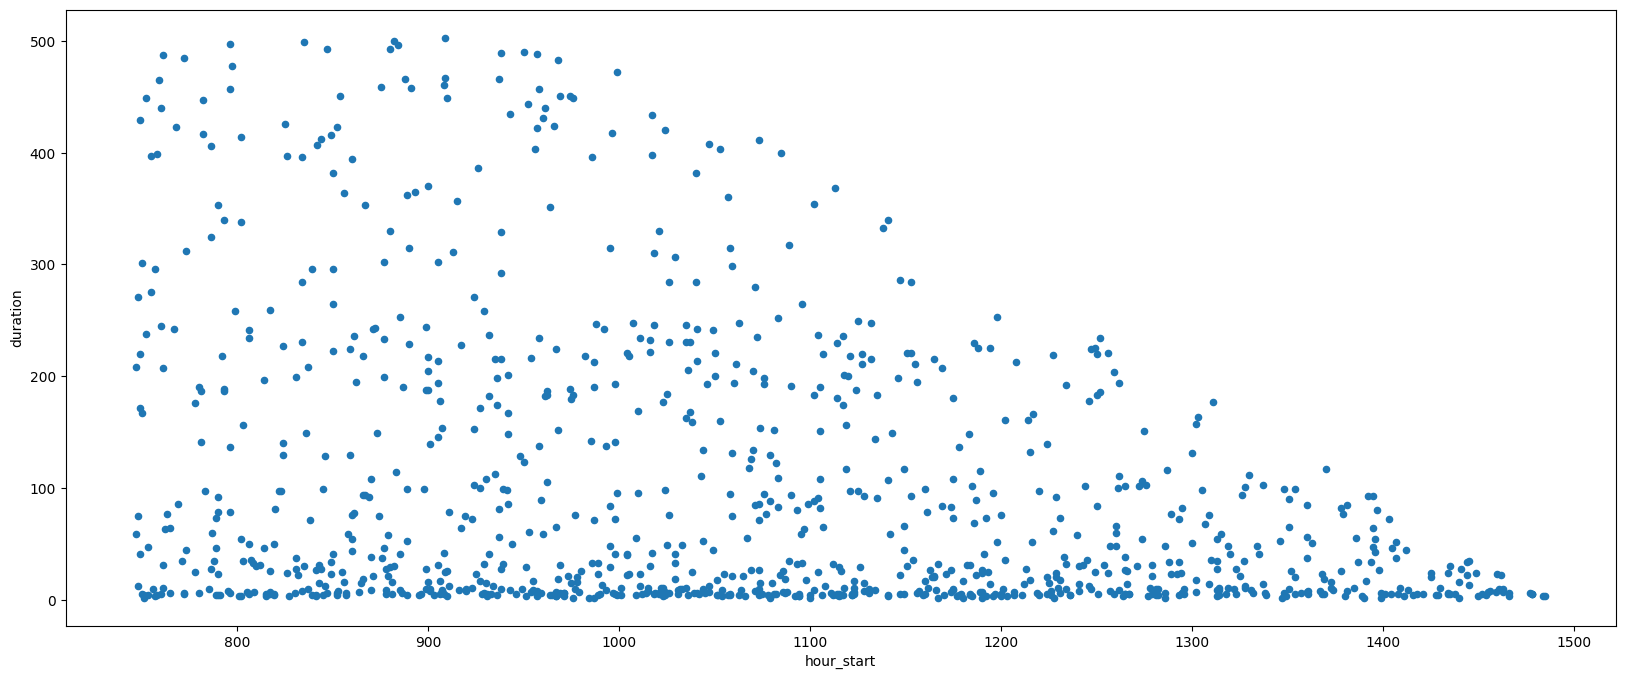

In [49]:
df_val_va.plot.scatter(x='hour_start', y='duration', figsize=(20, 8))
plt.xlabel('hour_start')
plt.ylabel('duration')

In [50]:
duration_median = df_val_va['duration'].median()
duration_median

36.5

In [51]:
# hist_users_ = hist_users.copy()
# # hist_users_['hour'] = hist_users_['hour'].round(-1)
# hist_users_['cpm'] = hist_users_['cpm'].round(-1)
# hu_stacked = hist_users_.drop(['sex', 'age', 'city_id'], axis=1) #.stack().reset_index(level=0, drop=True)
# hu_temp = hu_stacked.sort_values(['hour', 'cpm'])
# hu_temp['hour_cpm'] = hu_temp['hour'].astype(str)+'_'+hu_temp['cpm'].astype(str)
# # hu_temp.set_index('hour_cpm', inplace=True)
# hu_temp.reset_index(drop=True, inplace=True)
# hu_temp.head(15)

Количество уникальных пользователей

In [ ]:
# len(hu_temp['user_id'].unique())

NameError: name 'hu_temp' is not defined

Выберем аукционы для более глубокого изучения. Критерии отбора соответствуют аукциону с индексом 1, чтобы проверить вероятности at_least_one, at_least_two, at_least_three

In [53]:
df_2 = df_val_va[(df_val_va['hour_start']==1295) & (df_val_va['hour_end']==1301)]
df_2

,cpm,hour_start,hour_end,audience_size,duration,publisher_id,user_id,publishers_count,at_least_one,at_least_two,at_least_three,middle_hour
1,312.0,1295,1301,1380,6,"[3, 18]","[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",2,0.0130,0.0,0.0,1298
741,50.0,1295,1301,1380,6,"[3, 5, 7, 11, 17]","[6, 19, 21, 46, 71, 72, 87, 99, 132, 133, 152,...",5,0.0007,0.0,0.0,1298


Указанным критериям соответствуют два аукциона. Заметим, что существует пользователь, который находится в целевых списках обоих аукционов - 218. Найдем его в истории просмотров

In [54]:
user_218 = df_hist[(df_hist['user_id'] == 218)].sort_values('hour')
user_218

,hour,cpm,publisher,user_id
10080,7,90.00,2,218
1124970,10,80.00,7,218
41231,55,58.64,2,218
1007973,58,115.92,7,218
39445,62,31.54,2,218
...,...,...,...,...
934756,1413,252.00,2,218
954753,1416,70.00,7,218
1138736,1424,585.00,2,218
948159,1439,252.00,2,218


проверим на каких площадках он смотрит объявления

In [55]:
user_218['publisher'].value_counts()

publisher
2    107
7     29
Name: count, dtype: int64

На двух 2 и 7. При этом больше всего на 2-й площадке, но этой площадки нет в списке аукциона с индексом 1.
Проверим сколько у него было просмотров в течение периода (1295, 1301), который соответствует аукциону с индексом 1

In [56]:
df_hist[(df_hist['user_id'] == 218) & (df_hist['hour']>=1295) & (df_hist['hour']<=1301)]

,hour,cpm,publisher,user_id
856447,1295,100.0,2,218


Указанный период времени он просмотрел одно объявление, но cpm равно 100 в то время, как аукционы с индексом 1 и 741, в которых пользователь 218 числится в целевых аудиториях, имеют cpm 312 и 50, соответственно. 

In [57]:
df_3 = df_val_va[(df_val_va['hour_start']<=1295) & (df_val_va['hour_end']>=1295) & (df_val_va['cpm'] == 100)]
df_3

,cpm,hour_start,hour_end,audience_size,duration,publisher_id,user_id,publishers_count,at_least_one,at_least_two,at_least_three,middle_hour
158,100.0,1186,1416,2280,230,[2],"[3, 9, 12, 26, 27, 62, 100, 101, 131, 143, 144...",1,0.0741,0.0513,0.0355,1301
230,100.0,1083,1335,996,252,[3],"[25, 31, 86, 91, 122, 131, 160, 174, 176, 203,...",1,0.0402,0.0171,0.0100,1209
751,100.0,1072,1307,1260,235,"[1, 7, 14, 19, 21]","[6, 8, 11, 20, 22, 24, 41, 88, 90, 185, 190, 2...",5,0.2865,0.1944,0.1429,1190


То есть по факту пользователь не увидел целевые объявления, но увидел другие с индексами 158, 230, 751.

In [58]:
df_3.loc[:, 'user_id'].apply(lambda x: 218 in x)


158    False
230    False
751     True
Name: user_id, dtype: bool

При этом пользователь 218 был в списке целевых пользователей только в аукционе с индексом 751, но с площадки 7.

Вывод: пользователи просматривают объявления, которые победили на аукционе при условии отбора: 
- время просмотра попадает во временной диапазон аукциона
- площадка, на которой целевой пользователь смотрит объявления, значится в аукционе
- целевой пользователь числится в списки целевой аудитории аукциона


### Теперь сделаем анализ целевых аудиторий в датасете `validate`

Оценим целевую аудиторию аукциона с индексом 1

In [59]:
df_2

,cpm,hour_start,hour_end,audience_size,duration,publisher_id,user_id,publishers_count,at_least_one,at_least_two,at_least_three,middle_hour
1,312.0,1295,1301,1380,6,"[3, 18]","[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",2,0.0130,0.0,0.0,1298
741,50.0,1295,1301,1380,6,"[3, 5, 7, 11, 17]","[6, 19, 21, 46, 71, 72, 87, 99, 132, 133, 152,...",5,0.0007,0.0,0.0,1298


Сначача посмотрим на признаки пользователей в количестве 1380 чел. из аукциона 741

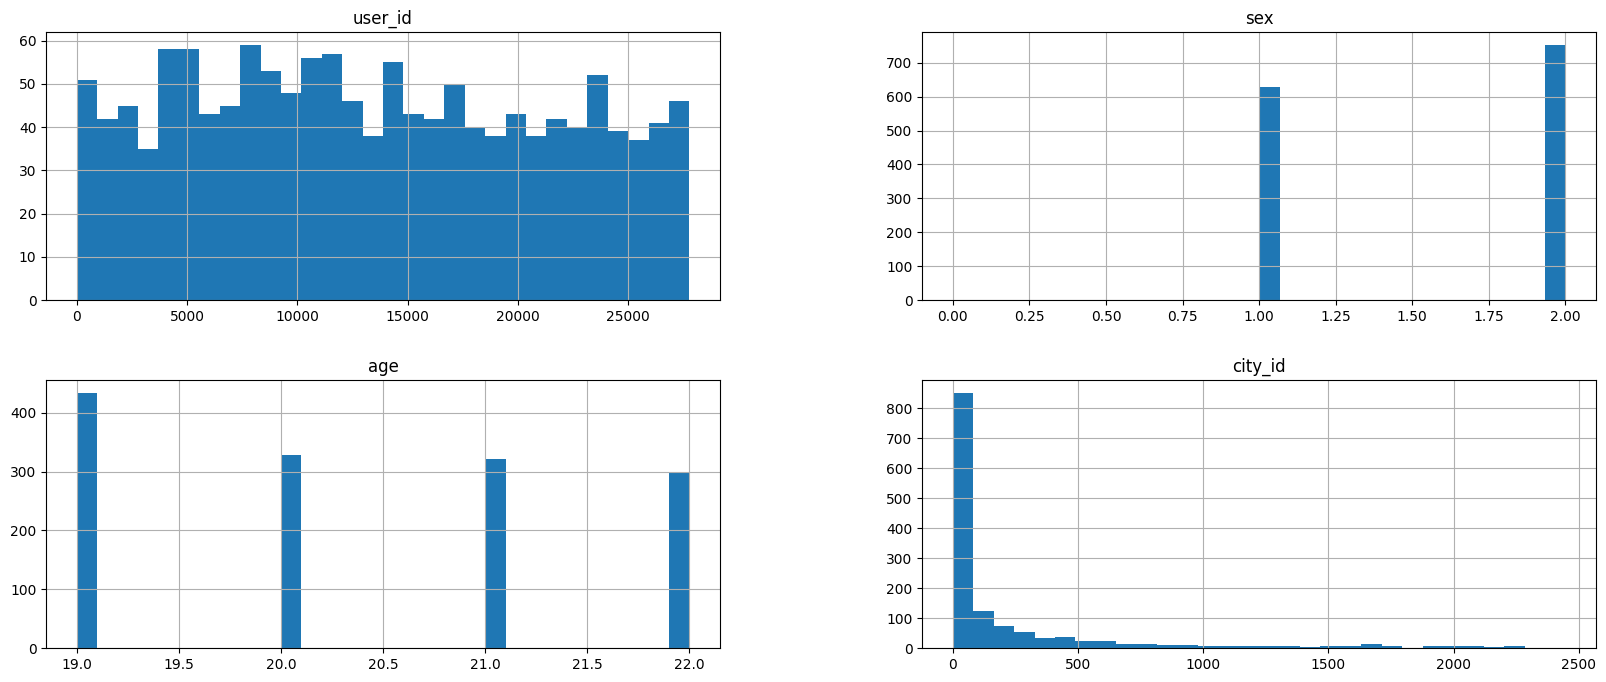

In [60]:
val_users_1 = df_2.iloc[1]['user_id']
val_users_1 = list(map(int, val_users_1))
vvv_1 = df_users.iloc[val_users_1]
vvv_1.hist(figsize=(20, 8), bins=30);

In [61]:
vvv_1['city_id'].value_counts()

city_id
0       417
3       109
7        44
19       23
60       20
       ... 
1409      1
202       1
797       1
1464      1
1953      1
Name: count, Length: 369, dtype: int64

Их всех объединяет узкий диапазон возраста и регион с городами с индексом 0, 3, и несколько других. Аудитория сбалансирована по полу.

Согласно параметрам аукциона с индексом 1 во время его показа (1295, 1301) на целевых площадках (3, 18) из целевой аудитории в 1380 чел реально просмотрело объявление 61 человек.

In [205]:
df_ = df_hist[(df_hist['hour']>=1295) & (df_hist['hour']<1301) & ((df_hist['publisher'] == 3) | (df_hist['publisher'] == 18))].sort_values('hour')
hu = df_['user_id'].sort_values().unique().tolist()
len(hu)

91

In [63]:
val_users_0 = df_2.iloc[0]['user_id']
intersect_0 = np.intersect1d(hu, val_users_0)
print(f'users_intersected: count {len(intersect_0)}, \nusers_list {intersect_0}')


users_intersected: count 18, 
users_list [   29  1837  2749  4315  4890  5717  5899  8244  8753  9748 10058 12083
 13267 15900 16330 19667 21150 26974]


In [64]:
df_2.loc[1, ['audience_size', 'at_least_one', 'at_least_two', 'at_least_three']]

audience_size      1380
at_least_one      0.013
at_least_two        0.0
at_least_three      0.0
Name: 1, dtype: object

In [65]:
len(intersect_0) / df_2.loc[1, ['audience_size']]

audience_size    0.013043
Name: 1, dtype: object

Для аукциона с индексом 1 была расчитана вероятность "хотя_бы_один" равная `1,3%` (датасет validate + validate_answers)
### В истории по факту есть только один пользователь (17437) из списка целевой аудитории, который увидел объявление с `cpm` = 50, вероятность такого просмотра равна `1,3043%` :)

In [70]:
hist_sorted = df_hist.sort_values(by=['user_id', 'hour'])
# Вычисление разницы в часах
hist_sorted['time_diff'] = hist_sorted.groupby('user_id')['hour'].diff()

In [214]:
hist_sorted.head()

,hour,cpm,publisher,user_id,time_diff
778194,1186,805.65,1,0,NaN
793167,1217,3302.01,1,0,31.0
305,8,165.00,1,1,NaN
1015,9,53.20,1,1,1.0
3458,9,36.00,1,1,0.0


In [215]:
df_val_va[df_val_va['at_least_two']==0]

,cpm,hour_start,hour_end,audience_size,duration,publisher_id,user_id,publishers_count,at_least_one,at_least_two,at_least_three,middle_hour
1,312.0,1295,1301,1380,6,"[3, 18]","[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",2,0.0130,0.0,0.0,1298
8,270.0,978,994,484,16,"[2, 11]","[52, 57, 139, 249, 290, 311, 327, 374, 488, 61...",2,0.0062,0.0,0.0,986
9,250.0,1440,1442,972,2,"[2, 3]","[46, 58, 176, 209, 255, 284, 305, 312, 367, 41...",2,0.0082,0.0,0.0,1441
12,80.0,1031,1040,624,9,"[2, 3, 7, 8, 19]","[146, 202, 377, 383, 385, 393, 436, 488, 602, ...",5,0.0176,0.0,0.0,1036
17,474.0,1001,1005,1660,4,"[2, 3, 6, 7, 18, 20]","[13, 28, 52, 66, 70, 94, 138, 164, 169, 202, 2...",6,0.0042,0.0,0.0,1003
...,...,...,...,...,...,...,...,...,...,...,...,...
991,220.0,979,986,680,7,"[1, 7, 14]","[18, 74, 217, 260, 283, 366, 398, 526, 562, 58...",3,0.0706,0.0,0.0,982
992,50.0,1094,1097,808,3,"[1, 2, 7, 13]","[9, 34, 51, 167, 186, 202, 232, 260, 311, 348,...",4,0.0087,0.0,0.0,1096
1002,430.0,1159,1163,384,4,"[1, 5, 7, 11, 13]","[202, 266, 355, 384, 390, 524, 655, 666, 696, ...",5,0.0651,0.0,0.0,1161
1004,90.0,1052,1056,484,4,"[2, 21]","[1, 4, 61, 212, 230, 348, 356, 372, 429, 431, ...",2,0.0165,0.0,0.0,1054


In [232]:
AUC_INDEX = 1

df_val_va.iloc[AUC_INDEX]

cpm                                                             312.0
hour_start                                                       1295
hour_end                                                         1301
audience_size                                                    1380
duration                                                            6
publisher_id                                                  [3, 18]
user_id             [29, 81, 98, 102, 165, 167, 195, 205, 218, 231...
publishers_count                                                    2
at_least_one                                                    0.013
at_least_two                                                      0.0
at_least_three                                                    0.0
middle_hour                                                      1298
Name: 1, dtype: object

In [233]:
auc_hour_start = df_val_va.loc[AUC_INDEX, 'hour_start']
auc_hour_end = df_val_va.loc[AUC_INDEX, 'hour_end']
auc_publishers = df_val_va.loc[AUC_INDEX, 'publisher_id']
auc_cpm = df_val_va.loc[AUC_INDEX, 'cpm']
auc_aud_size = df_val_va.loc[AUC_INDEX, 'audience_size']
targer_1 = df_val_va.loc[AUC_INDEX, 'at_least_one']

count = False

for pb in auc_publishers:
    _ = hist_sorted[
        (hist_sorted['hour']>=auc_hour_start) &
        (hist_sorted['hour']<auc_hour_end) &
        (hist_sorted['publisher'] == pb) #&
        # (df_hist['cpm'] == auc_cpm)
        ].sort_values('hour')
    users_watched_on_pl = _['user_id'].sort_values().unique().tolist()
    target_users = df_val_va.iloc[AUC_INDEX]['user_id']
    intersected = np.intersect1d(users_watched_on_pl, target_users).tolist()
    print(pb, intersected)
    if count:
        users_watched.extend(intersected)
    else:
        users_watched = intersected
        count = True

print(f'users_intersected_count = {len(users_watched)} for \n\
    auction_index - {AUC_INDEX} \n\
    with cpm - {auc_cpm} \n\
    on publisher - {pb} \n\
    targeted to - {auc_aud_size} users')
print(f'users_list - {users_watched}')
prob_calculated = round(len(users_watched) / auc_aud_size, 4)
print(f'Prob_1: {prob_calculated}')
print(f'Target_1: {targer_1}')

3 [29, 1837, 2749, 4315, 4890, 5717, 5899, 8244, 9748, 10058, 12083, 13267, 15900, 16330, 19667, 21150, 26974]
18 [8753]
users_intersected_count = 18 for 
    auction_index - 1 
    with cpm - 312.0 
    on publisher - 18 
    targeted to - 1380 users
users_list - [29, 1837, 2749, 4315, 4890, 5717, 5899, 8244, 9748, 10058, 12083, 13267, 15900, 16330, 19667, 21150, 26974, 8753]
Prob_1: 0.013
Target_1: 0.013


Ниже предобработка и функция свёртки, написанная "в лоб" (была идея через массивы, но время не стал тратить на более эффективные решения).
Свертка сворачивает массив history в сжатый формат, в которой плоащадки и пользователи в форме списков. ВАЖНО задать параметры свертки.
В моей случае округление признаков cpm и hour с их сцеплением в категориальный признак.

In [ ]:
# views = hu_stacked.groupby(['hour', 'cpm'], as_index=False)[['publisher', 'user_id']].count()
# views['hour_cpm'] = views['hour'].astype(str)+'_'+views['cpm'].astype(str)
# views.rename(columns={"publisher": "publisher_count", "user_id": "user_count"}, inplace=True)
# views.set_index('hour_cpm', inplace=True)

# views

In [ ]:
# def join_col_values(col_name: str)->pd.Series:
#     col_dict = {}
#     val_list = []
#     prev_row = hu_temp.loc[0, 'hour_cpm']

#     for row in list(hu_temp.index):
#         current_row = hu_temp.loc[row, 'hour_cpm']
#         if current_row == prev_row:
#             val_list.append(hu_temp.loc[row, col_name])
#         else:
#             col_dict[prev_row] = list(set(val_list))
#             prev_row = current_row
#             val_list = []
#             val_list.append(hu_temp.loc[row, col_name])

#     col_dict[prev_row] = list(set(val_list))

#     output = pd.Series(
#         index=col_dict.keys(),
#         data=col_dict.values(),
#         name=col_name
#         ).to_frame()

#     return output

In [ ]:
# df_pubs = join_col_values('publisher')
# df_pubs

In [ ]:
# df_us = join_col_values('user_id')
# df_us

### Результат

In [ ]:
hist_collapsed = pd.concat([views, df_pubs, df_us], axis=1)
hist_collapsed['publishers_count'] = hist_collapsed['publisher'].apply(func2)
hist_collapsed['users_count'] = hist_collapsed['user_id'].apply(func2)
col_to_drop = ['index', 'publisher_count', 'user_count']
hist_collapsed = hist_collapsed.reset_index().drop(col_to_drop, axis=1)
hist_collapsed

,hour,cpm,publisher,user_id,publishers_count,users_count
0,3,30,"[1, 2, 6, 7]","[8420, 6630, 15015, 19879, 8525, 8973, 3349, 2...",4,11
1,3,40,"[1, 2]","[15619, 8935, 15015, 4558, 22967]",2,5
2,3,50,"[1, 2, 4, 5]","[9513, 9198, 8305, 18129, 4020, 2972, 26622]",4,7
3,3,60,"[9, 2, 5, 1]","[11176, 14508, 17326, 15312, 3858, 3540, 3349,...",4,9
4,3,70,"[1, 2, 3]","[2597, 2928, 3858, 4127, 8765, 2911]",3,6
...,...,...,...,...,...,...
63944,1490,420,"[1, 2]","[8713, 26631]",2,2
63945,1490,430,[1],[19984],1,1
63946,1490,440,[1],"[25059, 15150]",1,2
63947,1490,450,[1],"[5569, 11923, 12748]",1,3


`hist_collapsed` аналогична `validate` и готова для предсказания, которое будет оцениваться.

Сравним распределения количества площадок и пользователей

In [ ]:
df_val_va['publishers_count'].value_counts()

NameError: name 'df_val_va' is not defined

In [ ]:
# hist_collapsed['publishers_count'].value_counts()

publishers_count
1     180778
2      77147
3      28722
4       9849
5       2732
6        781
7        423
8        252
9        109
10        43
11        13
12         1
Name: count, dtype: int64

Выше распределение без округления `cpm` и `hour`. Ниже с округлением `cpm` до десятков.

In [ ]:
hist_collapsed['publishers_count'].value_counts()

publishers_count
2     16916
3     15329
4     10714
1      9847
5      5345
6      2787
7      1571
8       828
9       383
10      171
11       45
12       13
Name: count, dtype: int64

In [ ]:
df_val_va['audience_size'].value_counts()


audience_size
1210    15
960     14
1232    14
2400    11
300     11
        ..
2357     1
2080     1
488      1
1140     1
2440     1
Name: count, Length: 205, dtype: int64

In [ ]:
hist_collapsed['users_count'].value_counts()

users_count
2      5717
3      5411
1      5297
4      4628
5      3870
       ... 
165       1
150       1
183       1
139       1
162       1
Name: count, Length: 167, dtype: int64

In [ ]:
# func4 = lambda x: np.intersect1d(х, х)

In [ ]:
# hu_temp_ = hu_temp.loc[:, ['hour', 'cpm']].drop_duplicates(ignore_index=True)
# hu_temp_['hour_cpm'] = hu_temp_['hour'].astype(str)+'_'+hu_temp_['cpm'].astype(str)
# hu_temp_.set_index('hour_cpm', inplace=True)
# hu_temp_

In [ ]:
# hu_ = hu_stacked.stack().reset_index(level=0, drop=True).index.loc(['publisher', 'user_id'])
# hu_stacked.groupby(hu_stacked.index).apply(list).to_frame().transpose()

### Обучим модель линейной регрессии

In [ ]:
from typing import Tuple
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
EPS = 0.005

In [ ]:
X = df_val_va.drop(['publisher_id', 'user_id', 'at_least_one', 'at_least_two', 'at_least_three'], axis=1)
y = df_val_va[['at_least_one', 'at_least_two', 'at_least_three']]

In [ ]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [ ]:
def log_mape_column_value(responses_column, answers_column, epsilon=EPS):
    return np.abs(np.log(
        (responses_column + epsilon) / (answers_column + epsilon)
    )).mean()

In [ ]:
def mean_log_accuracy_ratio(answers, responses, epsilon=EPS):
    log_accuracy_ratio_mean = np.array(
        [
            log_mape_column_value(responses.at_least_one, answers.at_least_one, epsilon),
            log_mape_column_value(responses.at_least_two, answers.at_least_two, epsilon),
            log_mape_column_value(responses.at_least_three, answers.at_least_three, epsilon),
        ]
    ).mean()

    percentage_error = 100 * (np.exp(log_accuracy_ratio_mean) - 1)

    return percentage_error.round(decimals=2)

In [ ]:
y_pred_data = pd.DataFrame()

In [ ]:
model_lr = LinearRegression(positive=True)
model_la = Lasso(alpha=1e-6,precompute=True,max_iter=10000,tol=1e-4,
            positive=False, random_state=42, selection='random')
model_sgdr = SGDRegressor(random_state=42)

models = {
    'LinearRegression': model_lr,
    'Lasso': model_la,
    'SGDRegression': model_sgdr
    }

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Обучим модели
for name in list(models.keys()):
    for i in list(y.columns):
        X_train, X_test, y_train, y_test = train_test_split(
            X_sc,
            y[i],
            test_size=0.2,
            random_state=42
            )
        # .fit(X_train, y_train)
        model_trained = models[name].fit(X_train,y_train)
        y_pred = model_trained.predict(X_test)
        y_pred_data[i] = y_pred

    errors = mean_log_accuracy_ratio(y_pred_data, y)
    print(f'Ошибка модели {name} для {i} на train: {(errors).mean()}', end='\n')
    y_pred_data[y_pred_data['at_least_two']<0]

Ошибка модели LinearRegression для at_least_three на train: 376.61
Ошибка модели Lasso для at_least_three на train: 376.48
Ошибка модели SGDRegression для at_least_three на train: 371.9
